In [42]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import causalpy as cp

In [ ]:
def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


def simulate_data(n=2500, alpha_true=3.0, rho=0.6, cate_estimation=False):
    # Exclusion restrictions:
    # X[0], X[1] affect both Y and T (confounders)
    # X[2], X[3] affect ONLY T (instruments for T)
    # X[4] affects ONLY Y (predictor of Y only)

    betaY = np.array(
        [0.5, -0.3, 0.0, 0.0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )  # X[2], X[3] excluded
    betaD = np.array(
        [0.7, 0.1, -0.4, 0.3, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    )  # X[4] excluded
    p = len(betaY)

    # noise variances and correlation
    sigma_U = 3.0
    sigma_V = 3.0

    # design matrix (n × p) with mean-zero columns
    X = np.random.normal(size=(n, p))
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    mean = [0, 0]
    cov = [[sigma_U**2, rho * sigma_U * sigma_V], [rho * sigma_U * sigma_V, sigma_V**2]]
    errors = np.random.multivariate_normal(mean, cov, size=n)
    U = errors[:, 0]  # error in outcome equation
    V = errors[:, 1]  #

    # continuous treatment
    T_cont = X @ betaD + V

    # latent variable for binary treatment
    T_latent = X @ betaD + V
    T_bin = np.random.binomial(n=1, p=inv_logit(T_latent), size=n)

    alpha_individual = 3.0 + 2.5 * X[:, 0]

    # outcomes
    Y_cont = alpha_true * T_cont + X @ betaY + U
    if cate_estimation:
        Y_bin = alpha_individual * T_bin + X @ betaY + U
    else:
        Y_bin = alpha_true * T_bin + X @ betaY + U

    # combine into DataFrame
    data = pd.DataFrame(
        {
            "Y_cont": Y_cont,
            "Y_bin": Y_bin,
            "T_cont": T_cont,
            "T_bin": T_bin,
        }
    )
    data["alpha"] = alpha_true + alpha_individual
    for j in range(p):
        data[f"feature_{j}"] = X[:, j]
    data["Y_cont_scaled"] = (data["Y_cont"] - data["Y_cont"].mean()) / data[
        "Y_cont"
    ].std(ddof=1)
    data["Y_bin_scaled"] = (data["Y_bin"] - data["Y_bin"].mean()) / data["Y_bin"].std(
        ddof=1
    )
    data["T_cont_scaled"] = (data["T_cont"] - data["T_cont"].mean()) / data[
        "T_cont"
    ].std(ddof=1)
    data["T_bin_scaled"] = (data["T_bin"] - data["T_bin"].mean()) / data["T_bin"].std(
        ddof=1
    )
    return data


data = simulate_data()
instruments_data = data.copy()
features = [col for col in data.columns if "feature" in col]
formula = "Y_cont ~ T_cont + " + " + ".join(features)
instruments_formula = "T_cont ~ 1 + " + " + ".join(features)
data

,Y_cont,Y_bin,T_cont,T_bin,alpha,feature_0,feature_1,feature_2,feature_3,feature_4,...,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,Y_cont_scaled,Y_bin_scaled,T_cont_scaled,T_bin_scaled
0,-3.622930,-4.426916,0.267995,0,7.231021,0.492408,-0.153387,0.632238,1.549490,-0.217191,...,-0.483356,0.541115,-0.438765,-0.419556,0.237334,-1.976732,-0.320051,-1.506112,0.089369,-0.985505
1,-7.762899,-1.634123,-2.042926,0,1.650064,-1.739974,-0.574608,-1.009005,0.327720,-0.879195,...,0.055404,-1.411090,-0.518275,0.152670,-1.120139,0.360184,-0.686483,-0.795379,-0.662693,-0.985505
2,11.977784,5.799723,3.059354,1,4.474363,-0.610255,-0.305802,-0.602653,1.882276,-0.000420,...,0.197202,-1.941906,-1.287992,0.237949,0.721191,0.151575,1.060779,1.096449,0.997784,1.014302
3,-5.484061,1.275083,-2.253048,0,5.692706,-0.122917,-0.315150,-1.469290,-0.717482,-0.439688,...,0.312800,-0.379406,-0.648433,0.649580,1.006272,0.927402,-0.484782,-0.055020,-0.731075,-0.985505
4,-12.907767,-2.415022,-3.497581,0,3.875030,-0.849988,-0.323205,0.319486,0.996123,-0.457897,...,0.802840,1.348549,-0.054392,1.038429,0.353959,-0.682012,-1.141859,-0.994109,-1.136093,-0.985505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-10.076508,-5.832192,-1.414772,0,9.270431,1.308172,-0.802954,-2.487989,1.100350,-1.214653,...,-1.632467,-0.454553,-2.521362,-1.285181,0.121284,-0.113719,-0.891262,-1.863739,-0.458268,-0.985505
2496,-1.382889,3.700458,-0.694449,1,6.743524,0.297409,0.430215,-1.670237,-1.288557,0.760799,...,0.797380,0.238452,-0.227972,-0.593133,1.936234,0.074842,-0.121784,0.562210,-0.223847,1.014302
2497,15.394511,4.097691,4.765607,1,6.960287,0.384115,0.306140,-0.810919,0.061464,-0.303729,...,-1.221077,0.501586,-0.505733,-0.299768,-1.878130,0.959871,1.363197,0.663301,1.553063,1.014302
2498,-1.563496,1.610554,-0.058017,1,7.299606,0.519842,0.687352,0.374898,-1.522148,0.237806,...,1.651592,1.484596,0.627287,0.012603,-0.208517,-0.946828,-0.137769,0.030354,-0.016728,1.014302


In [ ]:
sample_kwargs = {
    "draws": 1000,
    "tune": 2000,
    "chains": 2,
    "cores": 2,
    "mptarget_accept": 0.95,
    "progressbar": True,
    "random_seed": 42,
    "mp_ctx": "spawn",
}

# =========================================================================
# Model 1: Normal priors (no selection)
# =========================================================================
print("\n" + "-" * 80)
print("Model 1: Normal Priors (No Variable Selection)")
print("-" * 80)

result_normal = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type=None,  # No variable selection
)

# =========================================================================
# Model 2: Spike-and-Slab priors
# =========================================================================
print("\n" + "-" * 80)
print("Model 2: Spike-and-Slab Priors")
print("-" * 80)

result_spike_slab = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="spike_and_slab",
    vs_hyperparams={
        "pi_alpha": 2,
        "pi_beta": 2,
        "slab_sigma": 2,
    },
)


--------------------------------------------------------------------------------
Model 1: Normal Priors (No Variable Selection)
--------------------------------------------------------------------------------


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:172: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.
  """Validate the input data and model formula for correctness"""
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_t, beta_z, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 69 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:172: UserWarning: Warning. The treatment variable is not Binary.
                This is not necessarily a problem but it violates
                the assumption of a simple IV experiment.
                The coefficients should be interpreted appropriately.



--------------------------------------------------------------------------------
Model 2: Spike-and-Slab Priors
--------------------------------------------------------------------------------


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi_beta_t, beta_t_raw, gamma_beta_t_u, pi_beta_z, beta_z_raw, gamma_beta_z_u, chol_cov]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Output()

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 316 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [32]:
az.summary(result_normal.idata, var_names=["beta_z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_z[Intercept],0.015,0.059,-0.098,0.125,0.001,0.002,1658.0,1023.0,1.00
beta_z[T_cont],3.154,0.357,2.429,3.777,0.029,0.011,152.0,373.0,1.01
beta_z[feature_0],0.430,0.233,0.017,0.905,0.019,0.007,159.0,436.0,1.01
beta_z[feature_1],-0.383,0.059,-0.491,-0.277,0.001,0.002,1720.0,1250.0,1.00
beta_z[feature_2],0.030,0.162,-0.272,0.341,0.012,0.005,172.0,418.0,1.01
beta_z[feature_3],-0.055,0.143,-0.301,0.242,0.011,0.005,171.0,428.0,1.00
beta_z[feature_4],0.442,0.064,0.335,0.564,0.003,0.004,685.0,668.0,1.00
beta_z[feature_5],-0.000,0.058,-0.101,0.113,0.002,0.002,1338.0,970.0,1.00
beta_z[feature_6],0.027,0.061,-0.094,0.140,0.002,0.002,1184.0,1063.0,1.00
beta_z[feature_7],-0.037,0.058,-0.140,0.077,0.002,0.001,914.0,675.0,1.00


In [33]:
az.summary(result_spike_slab.idata, var_names=["beta_z"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_z[Intercept],0.001,0.010,-0.015,0.011,0.000,0.001,1035.0,807.0,1.00
beta_z[T_cont],3.076,0.099,2.900,3.269,0.006,0.004,286.0,340.0,1.00
beta_z[feature_0],0.476,0.086,0.323,0.648,0.004,0.002,477.0,571.0,1.00
beta_z[feature_1],-0.392,0.047,-0.480,-0.306,0.001,0.001,1903.0,1459.0,1.00
beta_z[feature_2],-0.000,0.018,-0.023,0.019,0.001,0.002,464.0,886.0,1.01
beta_z[feature_3],-0.003,0.021,-0.031,0.018,0.001,0.003,357.0,313.0,1.00
beta_z[feature_4],0.423,0.049,0.341,0.520,0.003,0.001,380.0,176.0,1.01
beta_z[feature_5],0.000,0.009,-0.012,0.008,0.000,0.001,629.0,1103.0,1.00
beta_z[feature_6],0.003,0.016,-0.012,0.033,0.000,0.001,781.0,1101.0,1.00
beta_z[feature_7],-0.005,0.019,-0.038,0.015,0.001,0.001,738.0,472.0,1.01


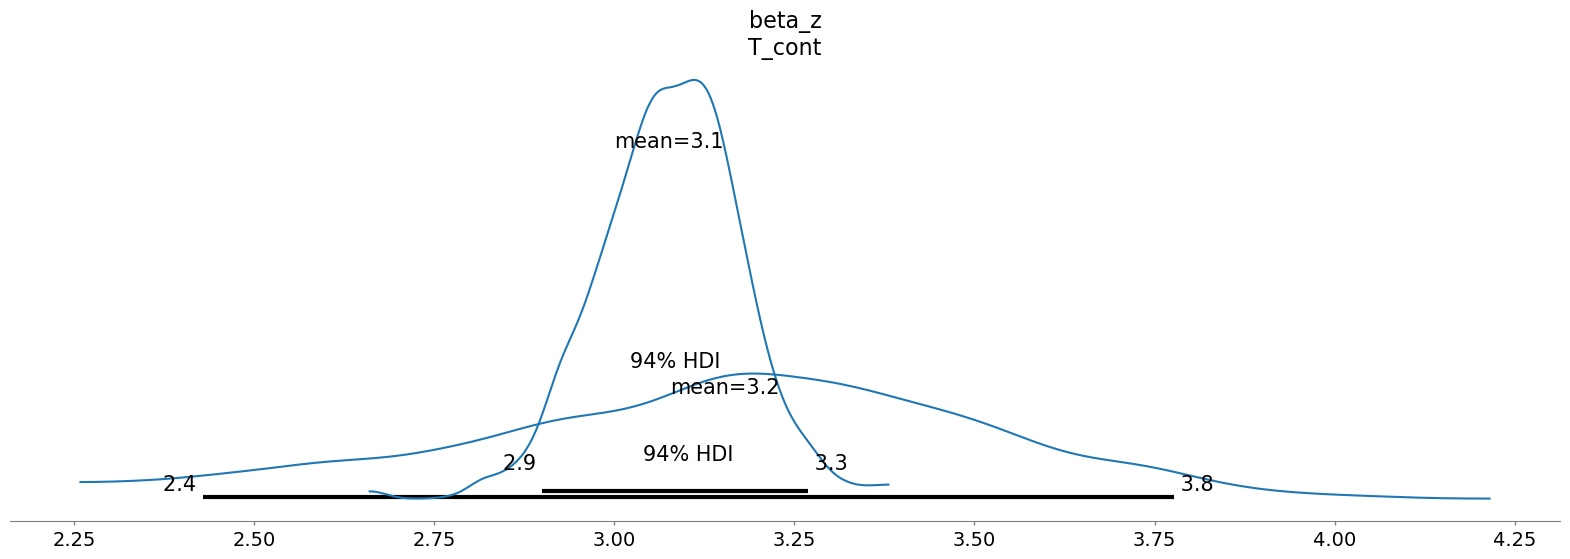

In [37]:
fig, ax = plt.subplots(figsize=(20, 6))
az.plot_posterior(
    result_normal.idata, var_names=["beta_z"], coords={"covariates": ["T_cont"]}, ax=ax
)
az.plot_posterior(
    result_spike_slab.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=ax,
);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

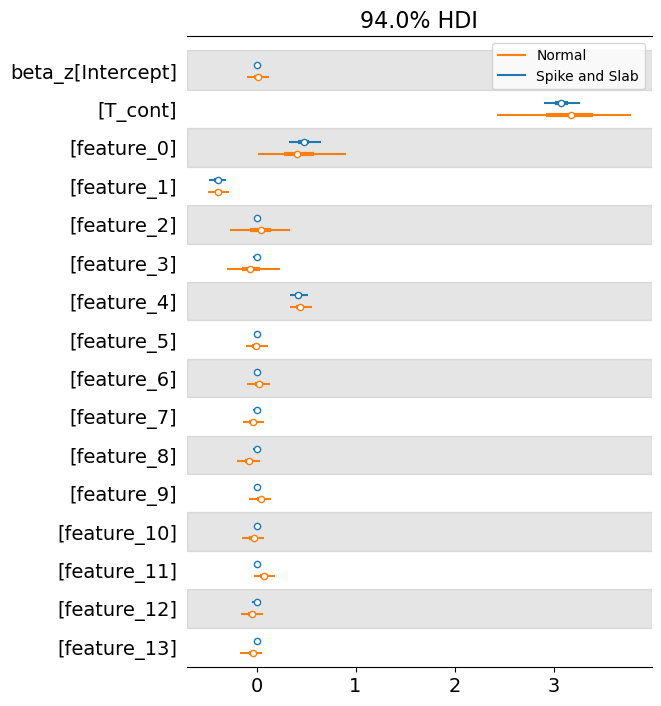

In [41]:
az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_z"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
)

## The Treatment Model

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

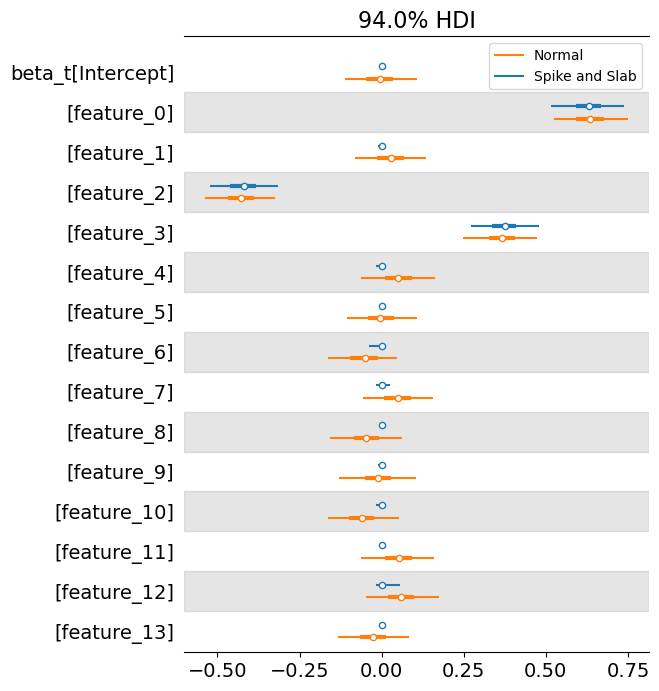

In [40]:
az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_t"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
)